In [22]:
import torch
import shutil
from tqdm import tqdm
from urllib.request import urlretrieve
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random
from random import sample
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
random.seed(42)

In [23]:
# PARAMS

LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 20

In [24]:
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, filepath):
    directory = os.path.dirname(os.path.abspath(filepath))
    os.makedirs(directory, exist_ok=True)
    if os.path.exists(filepath):
        print("Dataset already exists on the disk. Skipping download.")
        return

    with TqdmUpTo(unit="B", unit_scale=True, unit_divisor=1024, miniters=1, desc=os.path.basename(filepath)) as t:
        urlretrieve(url, filename=filepath, reporthook=t.update_to, data=None)
        t.total = t.n

def extract_archive(filepath):
    extract_dir = os.path.dirname(os.path.abspath(filepath))
    shutil.unpack_archive(filepath, extract_dir)

In [25]:
dataset_directory = os.path.join("./dataset")
# os.mkdir(dataset_directory)

filepath = os.path.join(dataset_directory, "images.tar.gz")
download_url(
    url="https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz", filepath=filepath,
)
extract_archive(filepath)

filepath = os.path.join(dataset_directory, "annotations.tar.gz")
download_url(
    url="https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz", filepath=filepath,
)
extract_archive(filepath)

Dataset already exists on the disk. Skipping download.
Dataset already exists on the disk. Skipping download.


In [26]:
root_directory = os.path.join(dataset_directory)
images_directory = os.path.join(root_directory, "images")
masks_directory = os.path.join(root_directory, "annotations", "trimaps")

def preprocess_mask(mask):
    mask = np.float32(mask)
    mask[mask == 2.0] = 0.0
    mask[(mask == 1.0) | (mask == 3.0)] = 1
    return Image.fromarray(np.uint8(mask))

class MaskToTensor(object):
    def __call__(self, mask):
        mask = np.float32(mask)
        mask[mask == 2.0] = 0.0
        mask[(mask == 1.0) | (mask == 3.0)] = 1
        return torch.unsqueeze(torch.from_numpy(mask),dim=0)

In [27]:
filenames = [os.path.splitext(f)[0] for f in os.listdir(images_directory) if os.path.isfile(os.path.join(images_directory, f))]

In [28]:
train_images_filenames = sample(filenames,int(len(filenames)*0.7))
leftover_images_filenames = list(set(filenames).difference(set(train_images_filenames)))
val_images_filenames = sample(leftover_images_filenames,int(len(leftover_images_filenames)*0.3))
test_images_filenames = list(set(leftover_images_filenames).difference(set(val_images_filenames)))

print(f'train_images_filenames has {len(train_images_filenames)} images')
print(f'val_images_filenames has {len(val_images_filenames)} images')
print(f'test_images_filenames has {len(test_images_filenames)} images')

train_images_filenames has 5175 images
val_images_filenames has 665 images
test_images_filenames has 1552 images


In [100]:
def display_image_grid(images_filenames, images_directory, masks_directory, predicted_masks=None):
    cols = 3 if predicted_masks else 2
    rows = len(images_filenames)
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, cols*rows))
    for i, image_filename in enumerate(images_filenames):
        image = Image.open(os.path.join(images_directory, f'{image_filename}.jpg')).convert('RGB')
        mask = Image.open(os.path.join(masks_directory, f'{image_filename}.png'))
        mask = preprocess_mask(mask)
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i].convert("L")
            ax[i, 2].imshow(predicted_mask, interpolation="nearest")
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.show()

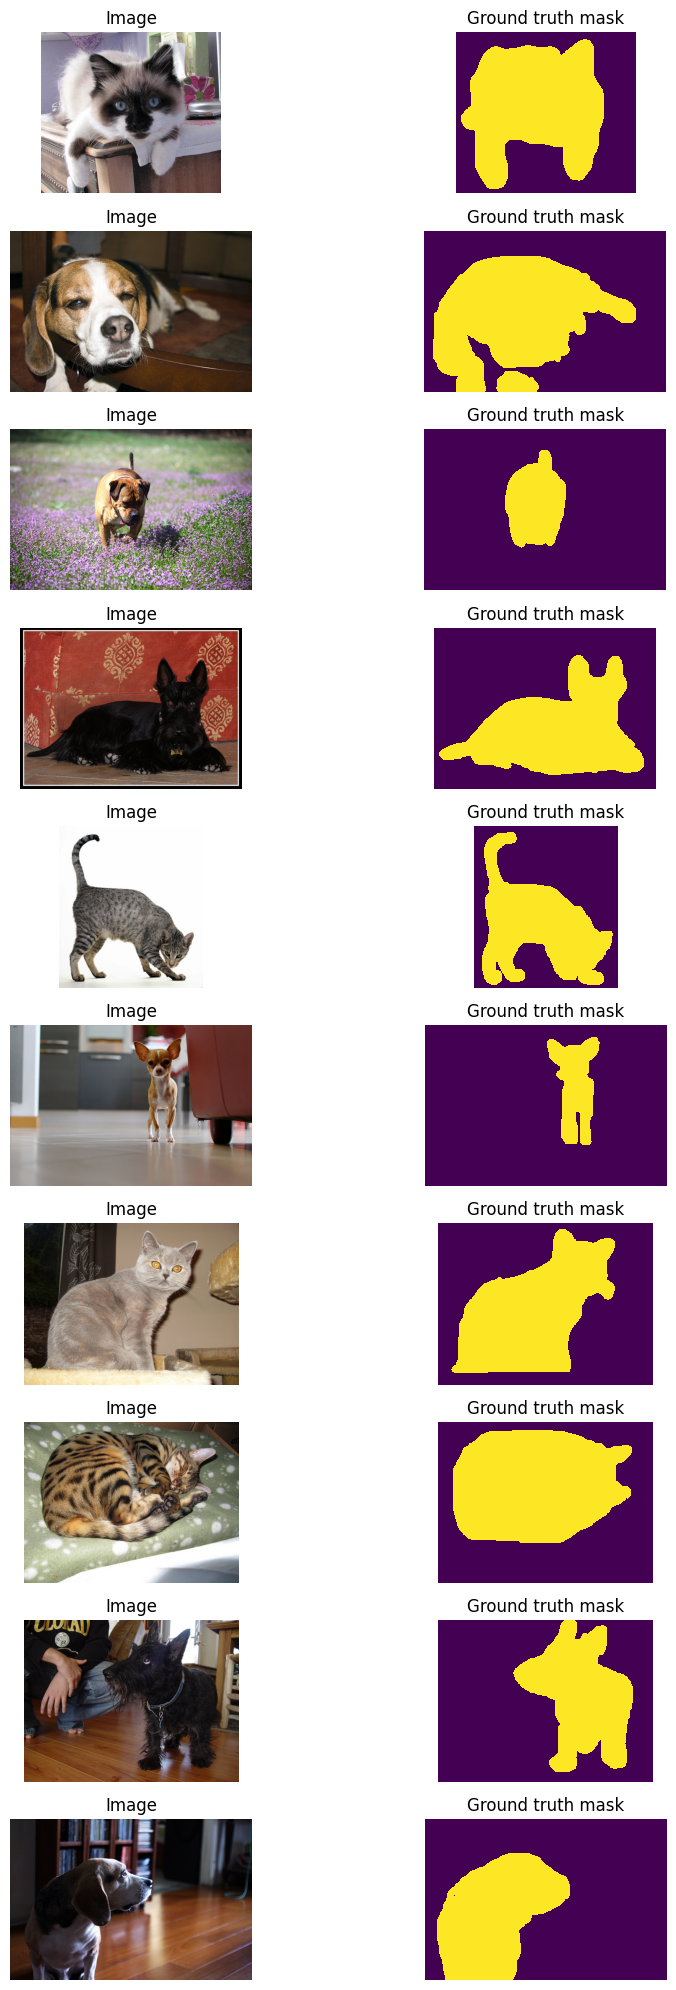

In [96]:
display_image_grid(train_images_filenames[:10], images_directory, masks_directory)

In [31]:
root_directory = os.path.join(dataset_directory)
images_directory = os.path.join(root_directory, "images")
masks_directory = os.path.join(root_directory, "annotations", "trimaps")

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, image_filenames, mask_filenames, transform_rgb=None, transform_bw=None):
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.transform_rgb = transform_rgb
        self.transform_bw = transform_bw

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image = Image.open(self.image_filenames[idx]).convert('RGB')
        mask = Image.open(self.mask_filenames[idx])
        if self.transform_rgb:
            image = self.transform_rgb(image)
        if self.transform_bw:
            mask = self.transform_bw(mask)
        return image, mask

# Define transforms
transform_rgb = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_bw = transforms.Compose([
    transforms.Resize((256, 256)),
    MaskToTensor()
])

# Create file lists for images and masks
train_images_locations = [os.path.join(images_directory, f'{image_filename}.jpg') for image_filename in train_images_filenames]
val_images_locations = [os.path.join(images_directory, f'{image_filename}.jpg') for image_filename in val_images_filenames]
train_masks_locations = [os.path.join(masks_directory, f'{image_filename}.png') for image_filename in train_images_filenames]
val_masks_locations = [os.path.join(masks_directory, f'{image_filename}.png') for image_filename in val_images_filenames]

# Create custom datasets
train_dataset = CustomDataset(train_images_locations, train_masks_locations, transform_rgb=transform_rgb, transform_bw=transform_bw)
val_dataset = CustomDataset(val_images_locations, val_masks_locations, transform_rgb=transform_rgb, transform_bw=transform_bw)

# Create DataLoaders for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Unet Implementation

In [37]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [38]:
def dice_score(output, target, smooth=1):
    output_flat = output.view(-1)
    target_flat = target.view(-1)
    intersection = (output_flat * target_flat).sum()
    return (2. * intersection + smooth) / (output_flat.sum() + target_flat.sum() + smooth)

In [39]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class Model(nn.Module):
    def __init__(self,in_channels=3, out_channels=1, features= (64,128,256) ):
        super(Model, self).__init__()
        self.features = features
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.max_pool = nn.MaxPool2d(2,2)

        # down part of Unet
        for feature in features:
            self.downs.append(
                DoubleConv(in_channels,feature)
            )
            in_channels = feature

        # up part of Unet
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature*2, feature, 2, 2)
                            )
            self.ups.append(
                DoubleConv(feature*2, feature)
            )
        self.bottle_neck = DoubleConv(features[-1], 2 * features[-1])
        self.final_conv = nn.Conv2d(features[0],out_channels, 1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.max_pool(x)

        x = self.bottle_neck(x)
        skip_connections.reverse()

        for idx in range(0,len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            concat_skip = torch.cat((skip_connection,x),dim=1)
            x = self.ups[idx + 1](concat_skip)
        return self.final_conv(x)

    def save(self, model_name):
        if not os.path.exists(".models/"):
            os.makedirs(".models/")
        PATH = f'.models/{model_name}.pth'
        torch.save(self.state_dict(), PATH)

    def load(self, model_name):
        PATH = f'.models/{model_name}.pth'
        self.load_state_dict(torch.load(PATH))

    def train_model(self, train_loader, val_loader,epochs=EPOCHS):

        optimizer = torch.optim.Adam(self.parameters(),lr=LR)
        criterion = nn.BCEWithLogitsLoss()
        scaler = GradScaler()

        for epoch in range(epochs):
            self.train()
            for inputs, targets in tqdm(train_loader, desc=f'in train, epoch {epoch+1} '):
                inputs = inputs.to(DEVICE)
                targets = targets.to(DEVICE)
                optimizer.zero_grad()

                with autocast():
                    outputs = self(inputs)
                    loss = criterion(outputs, targets)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

            self.eval()
            with torch.no_grad():
                val_loss = 0
                num_correct = 0
                num_pixels = 0
                dice = 0
                for inputs, targets in tqdm(val_loader, desc=f'in validation, epoch {epoch+1} '):
                    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                    with autocast():
                        outputs = self(inputs)
                        val_loss = criterion(outputs, targets)
                    preds = torch.sigmoid(outputs) > 0.5
                    num_correct += (preds == targets).sum()
                    num_pixels += torch.numel(preds)
                    dice += dice_score(preds, targets)

                val_loss /= len(val_loader)
                val_acc = num_correct/ num_pixels
                dice /= len(val_loader)

            print(f'Epoch {epoch+1}/{epochs}')
            print(f'Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.4f}, Dice score: {dice:.4f}')
            if not epoch+1 % 5:
                self.save(f'Unet_{epoch+1}')

In [40]:
model = Model(3,1)
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")
model.to(DEVICE)
model.train_model(train_dataloader, val_dataloader)

Number of parameters: 7700161


in validation, epoch 1 : 100%|██████████| 21/21 [00:09<00:00,  2.23it/s]


Epoch 1/20
Validation loss: 0.0305, Validation accuracy: 0.7181, Dice score: 0.7181


in validation, epoch 2 : 100%|██████████| 21/21 [00:06<00:00,  3.37it/s]


Epoch 2/20
Validation loss: 0.0192, Validation accuracy: 0.8188, Dice score: 0.7858


in validation, epoch 3 : 100%|██████████| 21/21 [00:08<00:00,  2.60it/s]


Epoch 3/20
Validation loss: 0.0161, Validation accuracy: 0.8451, Dice score: 0.8189


in validation, epoch 4 : 100%|██████████| 21/21 [00:06<00:00,  3.38it/s]


Epoch 4/20
Validation loss: 0.0162, Validation accuracy: 0.8663, Dice score: 0.8348


in validation, epoch 5 : 100%|██████████| 21/21 [00:06<00:00,  3.40it/s]


Epoch 5/20
Validation loss: 0.0277, Validation accuracy: 0.8259, Dice score: 0.7523


in validation, epoch 6 : 100%|██████████| 21/21 [00:06<00:00,  3.36it/s]


Epoch 6/20
Validation loss: 0.0147, Validation accuracy: 0.8760, Dice score: 0.8419


in validation, epoch 7 : 100%|██████████| 21/21 [00:06<00:00,  3.40it/s]


Epoch 7/20
Validation loss: 0.0139, Validation accuracy: 0.8863, Dice score: 0.8556


in validation, epoch 8 : 100%|██████████| 21/21 [00:06<00:00,  3.39it/s]


Epoch 8/20
Validation loss: 0.0112, Validation accuracy: 0.8901, Dice score: 0.8734


in validation, epoch 9 : 100%|██████████| 21/21 [00:06<00:00,  3.43it/s]


Epoch 9/20
Validation loss: 0.0108, Validation accuracy: 0.9011, Dice score: 0.8838


in validation, epoch 10 : 100%|██████████| 21/21 [00:06<00:00,  3.42it/s]


Epoch 10/20
Validation loss: 0.0104, Validation accuracy: 0.9009, Dice score: 0.8826


in validation, epoch 11 : 100%|██████████| 21/21 [00:06<00:00,  3.41it/s]


Epoch 11/20
Validation loss: 0.0107, Validation accuracy: 0.9022, Dice score: 0.8845


in validation, epoch 12 : 100%|██████████| 21/21 [00:06<00:00,  3.42it/s]


Epoch 12/20
Validation loss: 0.0096, Validation accuracy: 0.9166, Dice score: 0.8996


in validation, epoch 13 : 100%|██████████| 21/21 [00:06<00:00,  3.41it/s]


Epoch 13/20
Validation loss: 0.0107, Validation accuracy: 0.9089, Dice score: 0.8918


in validation, epoch 14 : 100%|██████████| 21/21 [00:06<00:00,  3.42it/s]


Epoch 14/20
Validation loss: 0.0113, Validation accuracy: 0.9156, Dice score: 0.8963


in validation, epoch 15 : 100%|██████████| 21/21 [00:06<00:00,  3.42it/s]


Epoch 15/20
Validation loss: 0.0094, Validation accuracy: 0.9213, Dice score: 0.9041


in validation, epoch 16 : 100%|██████████| 21/21 [00:06<00:00,  3.43it/s]


Epoch 16/20
Validation loss: 0.0093, Validation accuracy: 0.9077, Dice score: 0.8942


in validation, epoch 17 : 100%|██████████| 21/21 [00:08<00:00,  2.59it/s]


Epoch 17/20
Validation loss: 0.0096, Validation accuracy: 0.9211, Dice score: 0.9044


in validation, epoch 18 : 100%|██████████| 21/21 [00:06<00:00,  3.39it/s]


Epoch 18/20
Validation loss: 0.0111, Validation accuracy: 0.9183, Dice score: 0.8997


in validation, epoch 19 : 100%|██████████| 21/21 [00:07<00:00,  2.86it/s]


Epoch 19/20
Validation loss: 0.0096, Validation accuracy: 0.9232, Dice score: 0.9063


in validation, epoch 20 : 100%|██████████| 21/21 [00:06<00:00,  3.38it/s]

Epoch 20/20
Validation loss: 0.0096, Validation accuracy: 0.9230, Dice score: 0.9088


In [68]:
test_images_locations = [os.path.join(images_directory, f'{image_filename}.jpg') for image_filename in test_images_filenames]
test_masks_locations = [os.path.join(masks_directory, f'{image_filename}.png') for image_filename in test_images_filenames]

# Create custom datasets
test_dataset = CustomDataset(test_images_locations, test_masks_locations, transform_rgb=transform_rgb, transform_bw=transform_bw)

# Create DataLoaders for training and validation
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [70]:
model = Model(3,1).to(DEVICE)
model.load('Unet_20')
with torch.no_grad():
    num_correct = 0
    num_pixels = 0
    dice = 0
    for input, target in tqdm(test_dataloader, desc='in test '):
        input, target = input.to(DEVICE), target.to(DEVICE)
        with autocast():
            output = model(input)
        pred = torch.sigmoid(output) > 0.5
        num_correct += (pred == target).sum()
        num_pixels += torch.numel(pred)
        dice += dice_score(pred, target)

    test_acc = num_correct/ num_pixels
    dice /= len(test_dataloader)

print(f'Test accuracy: {test_acc:.4f},Test Dice score: {dice:.4f}')

in test : 100%|██████████| 156/156 [00:15<00:00, 10.12it/s]

Test accuracy: 0.9099,Test Dice score: 0.8899


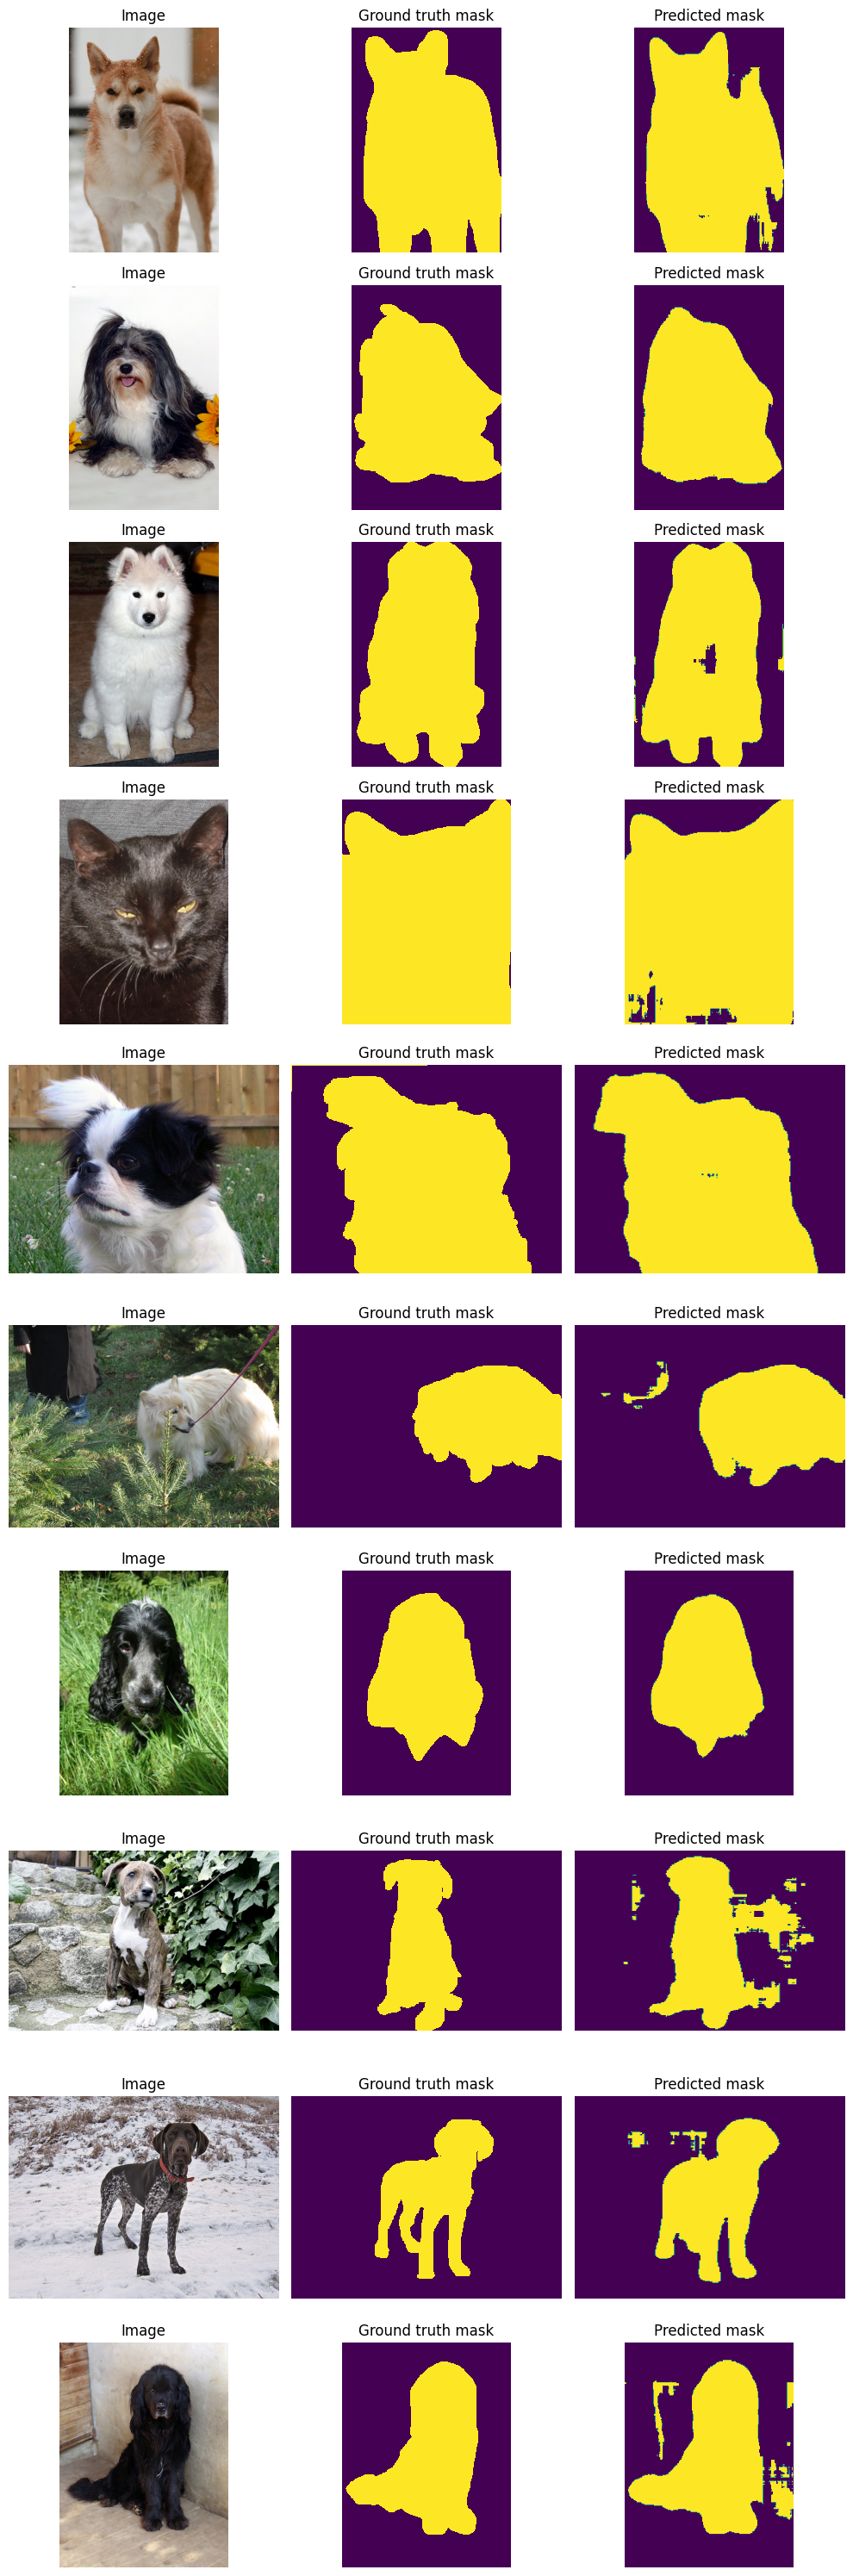

In [101]:
trans = transforms.ToPILImage()
my_iter = iter(test_dataloader)
sizes = []
for image_filename in test_images_filenames[:10]:
    sizes.append(Image.open(os.path.join(masks_directory, f'{image_filename}.png')).size)
model = Model(3,1).to(DEVICE)
model.load('Unet_20')
model.eval()
with autocast():
    outputs = model(next(my_iter)[0].to(DEVICE))
output_masks = []
for output,size in zip(outputs,sizes):
    output_masks.append(trans((torch.sigmoid(output)>0.5).int()*255).resize(size))
display_image_grid(test_images_filenames[:10], images_directory, masks_directory,predicted_masks=output_masks)